In [463]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Tanh
import pandas as pd
import optax

In [464]:
from model.nn import RealNVP, make_transform
from model.loss import make_error_loss

In [ ]:
dim = 3
nlayers = 12
hidden = 6
activation = Tanh

transform = make_transform(hidden, activation)
flow_init = RealNVP(transform, nlayers)

rng = jax.random.PRNGKey(42)
init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, dim)

# basis = lambda tau: jnp.array([1.0, (tau[0]**2 - tau[1]**2)**2, tau[2]**2])
order = 4
# # indepent poly
# def basis(tau):
#     b = [1.0]
#     for idx in range(dim):
#         for power in range(1, order[idx]+1):
#             b.append(tau[idx]**power)
#     return jnp.array(b)
# mixed poly
def basis(tau):
    b = []
    for n0 in range(order+1):
        for n1 in range(0, order - n0 + 1):
            for n2 in range(0, order - n0 - n1 + 1):
                b.append(tau[0]**n0 * tau[1]**n1 * tau[2]**n2)
    return jnp.array(b)

_, train_loss, coefficients = make_error_loss(flow_forward, basis, "./h3/pes_morse_train.txt")
valid_loss, _, _ = make_error_loss(flow_forward, basis, "./h3/pes_morse_valid.txt")
test_loss, _, _ = make_error_loss(flow_forward, basis, "./h3/pes_morse_test.txt")
value_and_grad = jax.value_and_grad(train_loss, argnums=0, has_aux=False)

step_size = 5e-4

params_optimizer = optax.adam(step_size)
params_opt_state = params_optimizer.init(params)

In [466]:
@jax.jit
def step(params, params_opt_state):
    value, grad = value_and_grad(params)
    params_updates, params_opt_state = params_optimizer.update(grad, params_opt_state)
    params = optax.apply_updates(params, params_updates)
    return value, params, params_opt_state

In [467]:
train_loss_history = []
valid_loss_history = []
# test_loss_history = []
nsteps = 3000
for i in range(nsteps):
    value, params, params_opt_state = step(params, params_opt_state)
    u = coefficients(params)
    train_loss_history.append(value)
    valid_loss_history.append(valid_loss(params, u))
    # test_loss_history.append(test_loss(params, u0))
    print(i, value)
# print(u0)
print(test_loss(params, u))
output = flow_inverse(params, jnp.array([[0, 0, 0]]))

0 2.774509177426443e-05
1 2.704362957450801e-05
2 2.632063370897053e-05
3 2.5923345150669075e-05
4 2.5102278689223545e-05
5 2.451274867611153e-05
6 2.395471211096012e-05
7 2.3050993790074692e-05
8 2.1876788481950404e-05
9 2.0962947121810904e-05
10 2.0690654301477873e-05
11 1.9757751868049178e-05
12 1.903007780887367e-05
13 1.85195242846381e-05
14 1.7530455442282822e-05
15 1.658923563961634e-05
16 1.582433122196414e-05
17 1.55038454542622e-05
18 1.4334360363715826e-05
19 1.3750801339751373e-05
20 1.2098144592076476e-05
21 1.3171009040593984e-05
22 1.2601748541493651e-05
23 1.2338923656984857e-05
24 1.1527815403311603e-05
25 1.2146629490977778e-05
26 1.0982921281238456e-05
27 1.0727448119710048e-05
28 1.0506818596600631e-05
29 1.0298941585232257e-05
30 3.874491838334881e-06
31 1.0172762354446196e-05
32 1.0319928457402927e-05
33 1.035543710767306e-05
34 9.589185029426628e-06
35 1.0495915316335869e-05
36 1.035259431811375e-05
37 1.039787931463032e-05
38 1.0453400136140045e-05
39 1.00171896

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_2010/1486418869.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


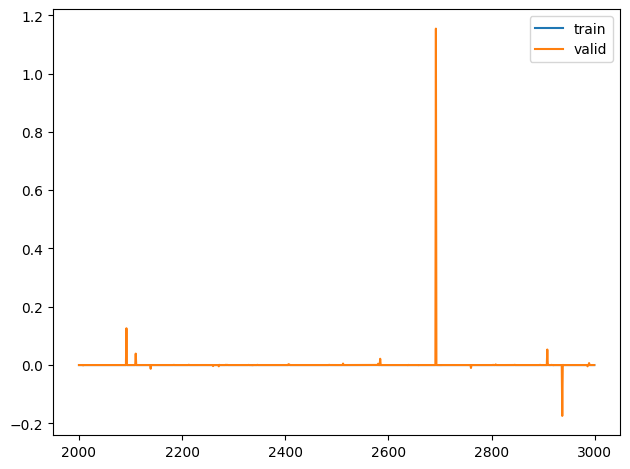

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
start_step = 1000
ax.plot(range(start_step, nsteps), train_loss_history[start_step:nsteps], label = "train")
ax.plot(range(start_step, nsteps), valid_loss_history[start_step:nsteps], label = "valid")
# ax.plot(range(start_step, nsteps), test_loss_history[start_step:nsteps], label = "test")
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [469]:
print(output[0])

[ 0.1223023  -0.52976072  0.45768671]


In [470]:
# print(jnp.acos(output[0][0]) * 180 / jnp.pi)
# print(-jnp.log(output[0][1]))
# print(-jnp.log(output[0][2]))

In [471]:
print(u)

[-1.58493017e+02 -1.22887269e+03 -1.14975355e+03  9.90150946e+03
  2.27681233e+04  6.81549533e+03  1.30438796e+03  1.00487417e+03
  8.78634645e+03  2.45749968e+04  3.03284134e+04  2.93321725e+04
  1.53412913e+04 -1.51256067e+03 -1.34155631e+04 -3.39692522e+04
 -2.58019350e+04  5.57009441e+03 -5.38613291e+02  3.77394514e+03
  1.13707032e+04 -1.82347974e+03  2.73563653e+03  2.41006306e+03
  9.10161032e+02 -1.94815746e+03 -9.11458814e+02  4.79883861e+02
 -2.69439565e+03 -1.38670825e+04 -1.89466319e+03  1.83460476e+04
 -1.28005680e+05 -2.21535434e+04  1.11251095e+04  6.81250031e+04
  1.32362014e+05  1.50349842e+05  5.26110413e+04 -2.85512489e+03
 -3.98383358e+04 -4.75561165e+04  7.57091590e+04 -2.08701124e+04
 -6.53631910e+03 -2.64551693e+04  1.75573216e+04  4.56562648e+03
 -4.37615856e+03 -9.54756326e+03 -5.08839320e+02  9.37140736e+03
 -5.32627827e+05  1.54257928e+05  2.57707149e+03 -8.71166710e+03
  2.10012471e+04 -4.99991271e+04  7.64414532e+04  7.37527851e+04
  1.97334662e+05 -5.14686

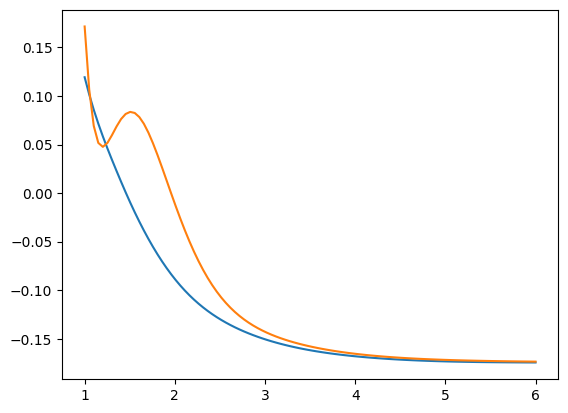

In [472]:
theta = jnp.pi / 4
r_h2 = 0.7414 / 0.53
r = jnp.linspace(1, 6, 100)
inputs = jnp.array([jnp.exp(-jnp.array([r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*rr*r_h2*jnp.cos(theta))])) for rr in r])
outputs = flow_forward(params, inputs)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
energy = jax.vmap(transformed_pes)(outputs)

from h3.bkmp2 import bkmp2
bkmp2_inputs = jnp.array([[r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*r_h2*rr*jnp.cos(theta))] for rr in r])
bkmp2_energy = [bkmp2(i, 0)[0] for i in bkmp2_inputs]

plt.plot(r, bkmp2_energy)
plt.plot(r, energy)
plt.show()

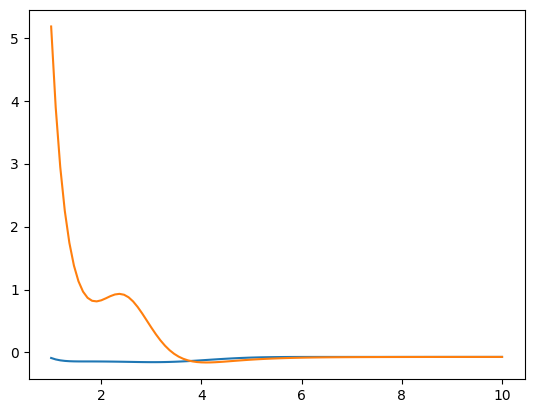

In [473]:
theta = jnp.pi / 6
r_h2 = 0.7414 / 0.53 * 2
r = jnp.linspace(1, 10, 100)
inputs = jnp.array([jnp.exp(-jnp.array([r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*rr*r_h2*jnp.cos(theta))])) for rr in r])
outputs = flow_forward(params, inputs)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
energy = jax.vmap(transformed_pes)(outputs)

from h3.bkmp2 import bkmp2
bkmp2_inputs = jnp.array([[r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*r_h2*rr*jnp.cos(theta))] for rr in r])
bkmp2_energy = [bkmp2(i, 0)[0] for i in bkmp2_inputs]

plt.plot(r, bkmp2_energy)
plt.plot(r, energy)
plt.show()